# Section 1: Create Tables

In [1]:
%load_ext sql

In [2]:
%sql sqlite://

'Connected: None@None'

In [3]:
%%sql
CREATE TABLE mail_Leads (First_name VARCHAR(20), 
                         Last_name VARCHAR(20), 
                         Mailing_address VARCHAR(20),
                         Electricity_util VARCHAR(30),
                         Util_id INTEGER,
                         State_id INTEGER,
                         County_id INTEGER,
                         Census_block_id INTEGER,
                         PRIMARY KEY (mailing_address));

Done.


[]

In [4]:
%%sql
CREATE TABLE mail_tracking (Table_id INTEGER, 
                            Mailing_name VARCHAR(20), 
                            Mailing_address VARCHAR(20),
                            Electricity_util VARCHAR(30),
                            Sent_date DATE,
                            Util_id INTEGER,
                            Num_of_mails INTEGER,
                            Census_tracking_code INTEGER);

Done.


[]

# Section 2: Queries

In [5]:
%%sql
/*1.Number of customer leads by state*/

select State_id, count(Mailing_address) as Num_of_customer_leads
from mail_Leads
group by State_id;

Done.


[]

In [6]:
%%sql
/*2.Number of distinct addresses in the file*/

select count(distinct Mailing_address) as Num_of_unique_addr
from mail_Leads;

Done.


Num_of_unique_addr
0


In [7]:
%%sql
/*3.Number of customer leads in each utility, grouped by state*/

select State_id, Util_id, count(Mailing_address) as Num_of_customer_leads
from mail_Leads
group by State_id, Util_id;

Done.


[]

In [8]:
%%sql
/*4.Concatenated census tracking code*/

select State_id || County_id || Census_block_id as concat_census_tracking_code
from mail_Leads;

Done.


[]

In [9]:
%%sql
/*5.The total number of mail pieces*/

select Table_id,sum(Num_of_mails) as total_num 
from mail_tracking
group by Table_id

Done.


[]

# Section3

## 1) Data Cleaning 

In [10]:
from collections import Counter
import pandas as pd
import numpy as np
import matplotlib.dates as dates
from __future__ import division
import datetime
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
%matplotlib inline

### Since I don't a test dataset, I will split 70% of the original dataset into training data,30% into test data. Although one customer may have multiple energy consumptions in different time, I consider the same person in different time to be two different people. So I will split splits on the entries rather than on the customer_id. And this split can simulate the real-world condition because sometimes the customer is an old customer, sometimes he/she is a new one.

In [11]:
data = pd.read_csv('test_usage_data.csv')
data.describe()

,customer_id,geoid1,geoid2,score
count,69874.000000,69874.000000,69874.000000,69874.000000
mean,104543.903226,4.877122,97.438489,0.499790
std,3009.858594,2.716258,42.969757,0.288483
min,100002.000000,1.000000,14.000000,0.000002
25%,101851.000000,3.000000,48.000000,0.250253
50%,104128.000000,4.000000,120.000000,0.498307
75%,107297.000000,8.000000,121.000000,0.751187
max,109999.000000,8.000000,173.000000,0.999963


In [12]:
x_col = ['customer_id','invoicefromdt','invoicetodt','invoicedate','geoid1','geoid2','score']
y_col = ['kwh']
X_train, X_test, y_train, y_test = train_test_split(data[x_col],data[y_col],test_size=0.3,random_state=456)

In [13]:
X_train.head()

,customer_id,invoicefromdt,invoicetodt,invoicedate,geoid1,geoid2,score
20989,103038,2015/6/16,2015/7/16,2015/7/17,8,114,0.530333
3849,100796,2015/4/14,2015/5/13,2015/5/15,1,120,0.879737
66575,107332,2015/4/28,2015/5/29,2015/6/1,3,35,0.241568
34057,109266,2014/12/11,2015/1/19,2015/1/21,2,42,0.597360
32365,109434,2015/2/23,2015/3/24,2015/3/26,4,16,0.775568


In [14]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48911 entries, 20989 to 30619
Data columns (total 7 columns):
customer_id      48911 non-null int64
invoicefromdt    48911 non-null object
invoicetodt      48911 non-null object
invoicedate      48911 non-null object
geoid1           48911 non-null int64
geoid2           48911 non-null int64
score            48911 non-null float64
dtypes: float64(1), int64(3), object(3)
memory usage: 3.0+ MB


### According to above, we need to convert the dates into datetime type; kwh to float type

In [15]:
def convert2date(df):
    return pd.to_datetime(df)

for col in data.columns[1:4]:
    X_train[col] = convert2date(X_train[col])
    X_test[col] = convert2date(X_test[col])
    
y_train['kwh'] = pd.to_numeric(y_train['kwh'])
y_test['kwh'] = pd.to_numeric(y_test['kwh'])

ValueError: Unable to parse string "(null)" at position 761

### Although there is error above, it is useful. According to it: 'ValueError: Unable to parse string "(null)" at position 761', there are Nan values in the 'kwh' column

In [16]:
count = 0
for item in y_train['kwh']:
    try:
        item = float(item)
    except Exception as e:
        count += 1
        print item
print 'Nan value proportion:{}%'.format(count / len(y_train)*100)

(null)
(null)
(null)
(null)
(null)
(null)
(null)
(null)
(null)
(null)
(null)
(null)
(null)
(null)
(null)
(null)
(null)
(null)
(null)
(null)
(null)
(null)
(null)
(null)
(null)
(null)
(null)
(null)
(null)
(null)
Nan value proportion:0.0613358958108%


### I print out all the values that can't be converted to float in case of multiple set of string values. It seems all the Nan values in the 'kwh' column are represented as '(null)'. Considering the proprotion of these nan values is small, only 0.06% of the training data. For simplicity, we can use the mean or median to fill these nan values.

In [16]:
y_train['kwh'] = pd.to_numeric(y_train['kwh'],errors='coerce')
y_train['kwh'] = y_train['kwh'].fillna(y_train['kwh'].mean(),axis=0)

In [17]:
# Cehck the result of filling
assert sum(pd.isnull(y_train['kwh'])) == 0, 'There is still Nan values'

In [18]:
y_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48911 entries, 20989 to 30619
Data columns (total 1 columns):
kwh    48911 non-null float64
dtypes: float64(1)
memory usage: 764.2 KB


## 2) Data Visualization & Feature engineering

### Drop customer id. But I don't want to lose the information that one customer had multiple purchases. So I create a  feature called usage_count as the number of purchases a user made.

In [19]:
hashtable = Counter(X_train['customer_id'])
X_train['usage_count'] = X_train['customer_id'].map(hashtable)

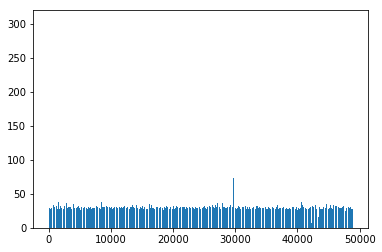

In [23]:
diff = X_train.invoicetodt-X_train.invoicefromdt
# Turn the difference to int
diff = map(lambda x: int(str(x)[:str(x).index(' ')]),diff)
ax = plt.subplot(111)
ax.bar(range(len(diff)),diff)
plt.show()

### The above figure shows the days betweeen invoicetodt and invoicefromdt. As is seen, almost all customer has the same days range. It can expected that its variance is small.

In [23]:
diff1 = X_train.invoicedate-X_train.invoicetodt
diff1 = map(lambda x: int(str(x)[:str(x).index(' ')]),diff1)
diff1 = np.array(diff1)

<Container object of 2 artists>

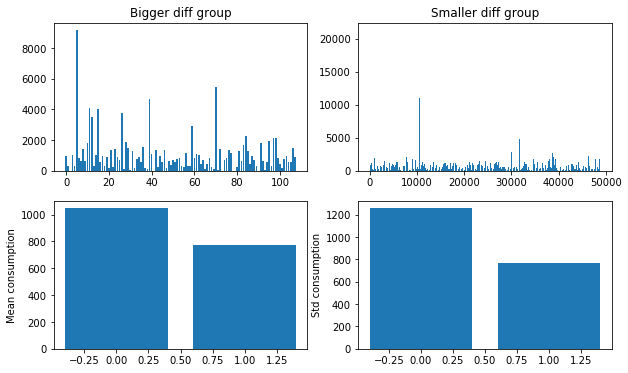

In [24]:
fig, axes = plt.subplots(2, 2,figsize=(10,6)) 
ax1,ax2,ax3,ax4 = axes[0,0],axes[0,1],axes[1,0],axes[1,1]

ax1.bar(xrange(len(y_train[diff1>100]['kwh'])),y_train[diff1>100]['kwh'])
ax1.set_title('Bigger diff group')

ax2.bar(xrange(len(y_train[diff1<=100]['kwh'])),y_train[diff1<=100]['kwh'])
ax2.set_title('Smaller diff group')

mean_diff= [np.mean(y_train[diff1>100]['kwh']),np.mean(y_train[diff1<=100]['kwh'])]
ax3.set_ylabel('Mean consumption')
ax3.bar(range(len(mean_diff)),mean_diff)

std_diff = np.std(y_train[diff1>100]['kwh']),np.std(y_train[diff1<=100]['kwh'])
ax4.set_ylabel('Std consumption')
ax4.bar(range(len(std_diff)),std_diff)

### As is seen from above, customers whose difference between the invoice date and the invoicetodate is bigger tends to have a bigger energy usage. But their variance is also big compared to those whose difference is smaller which means their consumption is less stable. So we can draw a simple conclusion: High risk, high profit. And this difference can be a informative feature which I will build later.

#### Mean & Std between invoicedate and invoicetodt

In [20]:
temp = X_train.invoicedate - X_train.invoicetodt
np.mean(temp),np.std(temp)

(Timedelta('3 days 08:52:05.480975'), Timedelta('12 days 12:33:00.389338'))

#### Mean & Std of diff between invoicetodt and invoicefromdt

In [21]:
temp = X_train.invoicetodt - X_train.invoicefromdt
np.mean(temp),np.std(temp)

(Timedelta('29 days 21:23:13.527018'), Timedelta('4 days 12:01:56.473802'))

### 1. As is seen above, the std of the diff between invoicetodt and invoicefromdt compared to its mean is far more smaller than that between the invoicedate and invoicetodt. It means alomst every customer has the same amout time during the invoice. So the diff between invoicetodt and invoicefromdt can' be a informative feature and I will drop the three columns concerning with date, then create a new feature with the difference between the invoicedate and invoicetodt which can be more informative.   
### 2. Here I don't consider about time-series analysis although the data is time-concerning and instead use the difference to substitute. That's beacause each customer is independent so actually the dates are not actually time-series.

In [22]:
X_train.head()

,customer_id,invoicefromdt,invoicetodt,invoicedate,geoid1,geoid2,score,usage_count
20989,103038,2015-06-16,2015-07-16,2015-07-17,8,114,0.530333,12
3849,100796,2015-04-14,2015-05-13,2015-05-15,1,120,0.879737,11
66575,107332,2015-04-28,2015-05-29,2015-06-01,3,35,0.241568,11
34057,109266,2014-12-11,2015-01-19,2015-01-21,2,42,0.597360,5
32365,109434,2015-02-23,2015-03-24,2015-03-26,4,16,0.775568,10


In [23]:
seasonmap = {3:1,4:1,5:1,   #Spring
             6:2,7:2,8:2,   #Summer
             9:3,10:3,11:3, #Autumn
             12: 0,1:0,2:0} #Winter

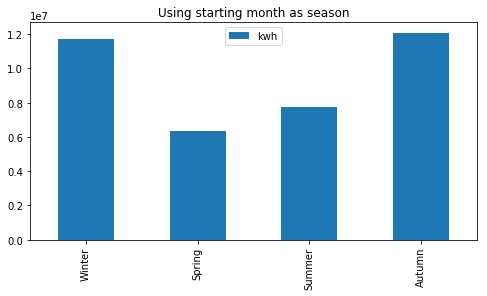

In [24]:
X_train['start_Month'] = map(lambda x: x.month, X_train['invoicefromdt'])
X_train['Season'] = X_train['start_Month'].map(seasonmap)
temp = pd.concat([X_train,y_train],axis=1)
season_sum = temp.groupby('Season')['kwh'].sum()
df = pd.DataFrame(season_sum)
df.index = ['Winter','Spring','Summer','Autumn']
df.plot(kind='bar',figsize=(8,4),title='Using starting month as season')

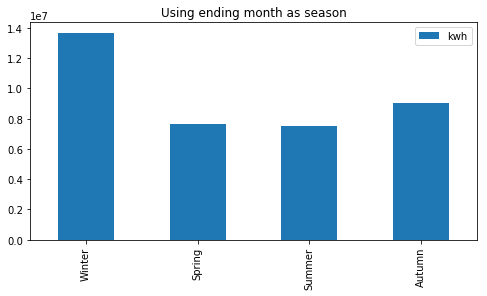

In [25]:
X_train['end_Month'] = map(lambda x: x.month, X_train['invoicetodt'])
X_train['Season'] = X_train['end_Month'].map(seasonmap)
temp = pd.concat([X_train,y_train],axis=1)
season_sum = temp.groupby('Season')['kwh'].sum()
df = pd.DataFrame(season_sum)
df.index = ['Winter','Spring','Summer','Autumn']
df.plot(kind='bar',figsize=(8,4),title='Using ending month as season')

### 1. In the figure called 'Using starting month as season', I use the starting month to map to the season the customer is in. For example, if the month is 3, it's 'spring' or if the month is 12, it's 'winter'. While in the figure called 'Using ending month as season', I use the ending month to map to the season. Whichever way I map, as is seen from above two figures, the overall energy consumption in winter and autumn is among the top 2, while in spring and summer, the consumption is among the lowest 2.  
###  2. And one thing to notice is that there is a big gap between the two figures in Autumn. As for the reason, My interpretation is that the overall geological position of all the customers may be in a relatively high latitude so the months of autumn and winter are generally longer and the temparature in these positions are lower.

In [26]:
X_train.head()

,customer_id,invoicefromdt,invoicetodt,invoicedate,geoid1,geoid2,score,usage_count,start_Month,Season,end_Month
20989,103038,2015-06-16,2015-07-16,2015-07-17,8,114,0.530333,12,6,2,7
3849,100796,2015-04-14,2015-05-13,2015-05-15,1,120,0.879737,11,4,1,5
66575,107332,2015-04-28,2015-05-29,2015-06-01,3,35,0.241568,11,4,1,5
34057,109266,2014-12-11,2015-01-19,2015-01-21,2,42,0.597360,5,12,0,1
32365,109434,2015-02-23,2015-03-24,2015-03-26,4,16,0.775568,10,2,1,3


In [27]:
# Convert to diff feature and drop the three columns
X_train['diff'] = X_train['invoicedate'] - X_train['invoicetodt']
X_train['diff'] = map(lambda x: int(str(x)[:str(x).index(' ')]), X_train['diff'])
X_train.drop(['customer_id','invoicefromdt','invoicetodt','invoicedate'],axis=1,inplace = True)
X_train.head()

,geoid1,geoid2,score,usage_count,start_Month,Season,end_Month,diff
20989,8,114,0.530333,12,6,2,7,1
3849,1,120,0.879737,11,4,1,5,2
66575,3,35,0.241568,11,4,1,5,3
34057,2,42,0.597360,5,12,0,1,2
32365,4,16,0.775568,10,2,1,3,2


In [28]:
"""
Groupby ['geoid1','geoid2'] and calculate the results' sum and mean energy usage
"""

temp =pd.concat([X_train,y_train],axis=1)
def build_coor(case):
    if case == 'sum':
        energy_usage = dict(temp.groupby(['geoid1','geoid2'])['kwh'].sum())
    else:
        energy_usage = dict(temp.groupby(['geoid1','geoid2'])['kwh'].mean())
    x,y,z = [],[],[]
    for key, value in energy_usage.items():
        x.append(key[0])
        y.append(key[1])
        z.append(value)
    return x,y,z

sum_x, sum_y, sum_z = build_coor('sum')
mean_x, mean_y, mean_z = build_coor('mean')

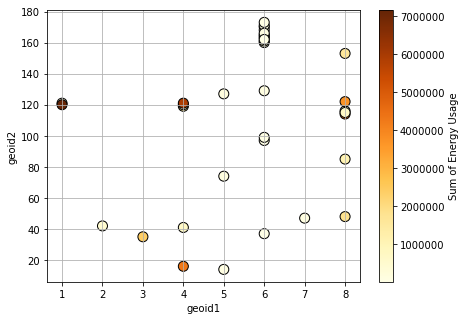

In [29]:
"""
Draw the overall energy usage in different places. The darker the color, the more it uses.
"""
plt.figure(figsize=(7,5))
plt.scatter(sum_x,sum_y, c=sum_z, s=100, cmap="YlOrBr", edgecolor="k")
plt.colorbar(label="Sum of Energy Usage")
plt.xlabel('geoid1')
plt.ylabel('geoid2')
plt.grid()
plt.show()

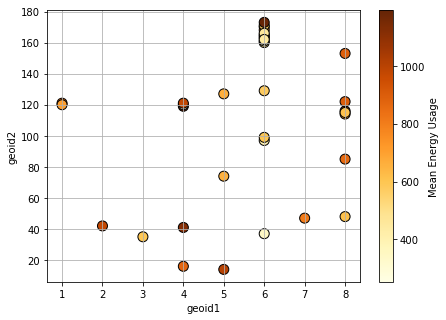

In [30]:
"""
Draw the overall energy usage in different places. The darker the color, the more it uses.
"""
plt.figure(figsize=(7,5))
plt.scatter(mean_x,mean_y, c=mean_z, s=100, cmap="YlOrBr", edgecolor="k")
plt.colorbar(label="Mean Energy Usage")
plt.xlabel('geoid1')
plt.ylabel('geoid2')
plt.grid()
plt.show()

### The above two figures respectively show the sum and  mean of the energy usage in different places. The darker the color is, the more energy that place uses. As is seen, generally speaking, customer whose geoid2 is low or high tend to have more energy usage. And the energy usage distribution in these two figures is alomost the same which means the places having more overall energy usage also has more mean energy usage.

### 3) Machine Learning

In [31]:
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor as GBR
from sklearn.svm import SVR
from sklearn import linear_model
from sklearn import tree
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import MinMaxScaler
import time

In [32]:
"""
Do the same transforamtion to the test data as the training data.
"""
X_test['usage_count'] = X_test['customer_id'].map(Counter(X_test['customer_id']))
X_test['diff'] = X_test.invoicedate - X_test.invoicetodt
X_test['diff'] = map(lambda x: int(str(x)[:str(x).index(' ')]),X_test['diff'])
X_test['end_Month'] = map(lambda x: x.month, X_test['invoicetodt'])
X_test['start_Month'] = map(lambda x: x.month, X_test['invoicefromdt'])
X_test['Season'] = X_test['end_Month'].map(seasonmap)
X_test.drop(['customer_id','invoicefromdt','invoicetodt','invoicedate'],axis=1,inplace = True)
X_test.head()

,geoid1,geoid2,score,usage_count,diff,end_Month,start_Month,Season
27995,8,114,0.439943,6,1,8,7,2
63592,4,41,0.630107,4,2,5,4,1
31343,1,120,0.821492,4,2,2,1,0
22266,1,120,0.470477,2,2,2,1,0
33144,5,74,0.145317,3,1,7,6,2


In [33]:
# Fill Nan in y_test
y_test['kwh'] = pd.to_numeric(y_test['kwh'],errors = 'coerce')
y_test['kwh'] = y_test['kwh'].fillna(y_test['kwh'].mean(),axis=0)

In [34]:
y_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20963 entries, 27995 to 32653
Data columns (total 1 columns):
kwh    20963 non-null float64
dtypes: float64(1)
memory usage: 327.5 KB


In [35]:
X_train.head()

,geoid1,geoid2,score,usage_count,start_Month,Season,end_Month,diff
20989,8,114,0.530333,12,6,2,7,1
3849,1,120,0.879737,11,4,1,5,2
66575,3,35,0.241568,11,4,1,5,3
34057,2,42,0.597360,5,12,0,1,2
32365,4,16,0.775568,10,2,1,3,2


### 1.Gradient Boosting Regression

In [36]:
"""
RMSE
"""
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

"""
Tune parameters
"""
def param_tune(col_name):
    start = time.clock()
    temp = X_train[col_name]
    grid = GridSearchCV(GBR(), param_grid={"n_estimators":range(50,210,10), 
                                           "learning_rate": [0.05,0.1,0.2,0.4],
                                           "random_state":[2017]}, 
                        scoring = 'neg_mean_squared_error',cv=5)
    grid.fit(temp.values,y_train.values)
    print("The best parameters are %s with a score of %0.2f"
          % (grid.best_params_, grid.best_score_))
    print 'Calculating time:{} mins'.format((time.clock() - start) / 60)
    return grid.best_params_


"""
Calculate three errors: MSE, MAE, RMSE
"""
def gbr_error(best_param,col_name):
    temp = X_train[col_name]
    gbr = GBR(n_estimators = best_param['n_estimators'],
              learning_rate=best_param['learning_rate'],
              random_state=best_param['random_state'])
    gbr.fit(temp,y_train.values)
    gbr_pred = gbr.predict(X_test[col_name])
    print 'GBR MSE:{}'.format(mse(y_test,gbr_pred))
    print 'GBR MAE:{}'.format(mae(y_test,gbr_pred))
    print 'GBR RMSE:{}'.format(rmse(y_test.values,gbr_pred))

#### Predicting Result of selecting columns ['geoid1','geoid2','score','diff']

In [42]:
best_param = param_tune(['geoid1','geoid2','score','diff','usage_count'])

The best parameters are {'n_estimators': 90, 'learning_rate': 0.2, 'random_state': 456} with a score of -464.11
Calculating time:385.474905116


In [47]:
gbr_error(best_param, ['geoid1','geoid2','score','diff','usage_count'])

GBR MSE:603818.809794
GBR MAE:518.774044668
GBR RMSE:816.9546471


#### Predicting Result of selecting columns ['geoid1','geoid2','score','diff','Season']

In [48]:
col_name = ['geoid1','geoid2','score','diff','Season']
best_param = param_tune(col_name)
gbr_error(best_param, col_name)

The best parameters are {'n_estimators': 190, 'learning_rate': 0.1, 'random_state': 456} with a score of -460.44
Calculating time:460.699165196
GBR MSE:529415.896706
GBR MAE:461.232416094
GBR RMSE:785.13852348


#### Predicting Result of selecting columns ['geoid1','geoid2','score','diff','Season','start_Month']

In [49]:
col_name = ['geoid1','geoid2','score','diff','Season','start_Month']
best_param = param_tune(col_name)
gbr_error(best_param, col_name)

The best parameters are {'n_estimators': 90, 'learning_rate': 0.2, 'random_state': 456} with a score of -453.44
Calculating time:525.568700956
GBR MSE:512141.259746
GBR MAE:453.030197092
GBR RMSE:794.138815995


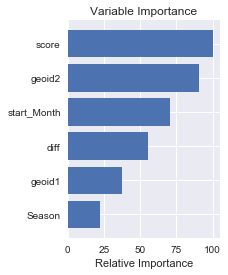

In [53]:
temp = X_train[col_name]
gbr = GBR(n_estimators = best_param['n_estimators'],
          learning_rate=best_param['learning_rate'],
          random_state=best_param['random_state'])
gbr.fit(temp,y_train.values)
feature_importance = gbr.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, temp.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.figure(figsize=(8,15))
plt.show()

### According to above error calculation, the best solution is as follows:
#### Features selected: ['geoid1','geoid2','score','diff','Season','start_Month']
#### Cross_validation evaluating metric: MAE
#### Best_parameters: 'n_estimators': 90, 'learning_rate': 0.2, 'random_state': 456
#### Best_error: MSE:512141.259746; MAE:453.030197092; RMSE:794.138815995

### The reason why I add one feature at a time and test the result is because the number of original features is small,so I need to build new features and I want to see how each added new featue can affect the result. And the feature importance is shown above.

### 2. Ridge Regression

In [55]:
norm = [Normalizer(), MaxAbsScaler(), MinMaxScaler()]
for method in norm:
    col_name = ['geoid1','geoid2','score','diff','Season','start_Month']
    temp = X_train[col_name]
    ridge = linear_model.RidgeCV(alphas=[0.1,0.5,1,10],cv=5)
    method.fit(temp,y_train.values)
    ridge_train = method.fit_transform(temp)
    ridge_test = MinMaxScaler().fit_transform(X_test[col_name])
    ridge.fit(ridge_train,y_train.values)
    ridge_pred = ridge.predict(ridge_test)
    print '{}'.format(method)
    print 'Ridge MSE:{}'.format(mse(y_test,ridge_pred))
    print 'Ridge MAE:{}'.format(mae(y_test,ridge_pred))
    print 'Ridge RMSE:{}'.format(rmse(y_test.values,ridge_pred))
    print '================================================='

Normalizer(copy=True, norm='l2')
Ridge MSE:2268691.18213
Ridge MAE:1228.36092113
Ridge RMSE:1506.21750824
MaxAbsScaler(copy=True)
Ridge MSE:562921.448668
Ridge MAE:487.478091925
Ridge RMSE:750.280913171
MinMaxScaler(copy=True, feature_range=(0, 1))
Ridge MSE:562855.018189
Ridge MAE:484.94424461
Ridge RMSE:750.23664146


### Since Ridge Regression is sensitive to the way that normalize the data, I tried three normalization and as seen from above, MinMaxScaler has the smaller MSE,MAE,RMSE compare to the other two. But the error is bigger than ensemble method Gradient Boosting Tree. It makes sense because generally ensemble methods is better than the linear model. 

### 3. Support Vetor Regression

In [ ]:
start = time.clock()
best_mae = 10**4
best_param = {'penalty':1,'C':1}
best_predictor = None

col_name = ['geoid1','geoid2','score','diff','Season','start_Month']
temp = X_train[col_name]
MinMaxScaler().fit(temp)
temp_train,temp_test = method.fit_transform(temp),method.fit_transform(X_test[col_name])
grid = GridSearchCV(SVR(), param_grid={"C":range(10,110,10), 
                                       "gamma": [1, 0.1, 0.01,0.001], 
                                       'kernel':['linear','rbf','poly']}, 
                    scoring = 'neg_mean_absolute_error',cv=5)
grid.fit(temp_train,y_train.values)
grid_pred = grid.predict(temp_test,y_test)
temp_score = mae(y_test,grid_pred)
print 'SVR MAE:{}'.format(temp_score)
print 'Total time:{}'.format(time.clock()-start)

### I've tried SVR to do regression. But the training and tuning parameters takes ages. Till I submit the test, it's still training. I leave my code here to show what I did.

### 4.Ensemble

In [37]:
import os

mingw_path = 'C:\\Program Files\\mingw-w64\\x86_64-6.3.0-posix-seh-rt_v5-rev1\\mingw64\\bin'

os.environ['PATH'] = mingw_path + ';' + os.environ['PATH']
from xgboost import XGBRegressor


In [39]:
from sklearn.cross_validation import KFold
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn import grid_search
from sklearn.metrics import mean_squared_error, make_scorer


In [43]:
def mean_squared_error_(ground_truth, predictions):
    return mean_squared_error(ground_truth, predictions) ** 0.5

RMSE = make_scorer(mean_squared_error_, greater_is_better=False)

def model_tune(model):
    start = time.clock()
    best_model = GridSearchCV(model, 
                              param_grid = {"n_estimators":range(50,210,10), 
                                            "learning_rate": [0.05,0.1,0.2,0.4],
                                            "random_state":[2017],
                                            "verbose": [1]},
                              n_jobs = 5,
                              scoring = RMSE,
                              cv=10)
    best_model.fit(X_train.values,y_train.values)
    print("The best parameters are %s with a score of %0.2f"
          % (best_model.best_params_, best_model.best_score_))
    print 'Calculating time:{} mins'.format((time.clock() - start) / 60)
    print '========================================================'
    return best_model.best_params_

In [ ]:
gbr_best_param = model_tune(GradientBoostingRegressor(random_state=2017,verbose=1))
etr_best_param = model_tune(ExtraTreesRegressor(random_state = 2017,verbose=1))
rf_best_param = model_tune(RandomForestRegressor(random_state = 2017,verbose=1))
xgb_best_param = model_tune(XGBRegressor(random_state = 2017,verbose=1))

In [75]:
base_models = [
        RandomForestRegressor(
            n_jobs=1, random_state=2016, verbose=1,
            n_estimators=100, 
        ),
        ExtraTreesRegressor(
            n_jobs=1, random_state=2016, verbose=1,
            n_estimators=100,
        ),
        GradientBoostingRegressor(
            random_state=2016, verbose=1,
            n_estimators=100,
            #learning_rate=0.05, subsample=0.8
        ),
        XGBRegressor(
            seed=2016,
            n_estimators=200,colsample_bytree=0.85,max_depth=8
        )
    ]

In [41]:
def mean_squared_error_(ground_truth, predictions):
    return mean_squared_error(ground_truth, predictions) ** 0.5

RMSE = make_scorer(mean_squared_error_, greater_is_better=False)

In [42]:
class Ensemble(object):
    def __init__(self, n_folds, stacker, base_models):
        self.n_folds = n_folds
        self.stacker = stacker
        self.base_models = base_models

    def fit_predict(self, X, y, T):
        X = np.array(X)
        y = np.array(y)
        T = np.array(T)

        folds = list(KFold(len(y), n_folds=self.n_folds, shuffle=True, random_state=2016))

        S_train = np.zeros((X.shape[0], len(self.base_models)))
        S_test = np.zeros((T.shape[0], len(self.base_models)))

        for i, clf in enumerate(self.base_models):

            print('Fitting For Base Model #{0} / {1} ---'.format(i+1, len(self.base_models)))

            S_test_i = np.zeros((T.shape[0], len(folds)))

            for j, (train_idx, test_idx) in enumerate(folds):

                print('--- Fitting For Fold #{0} / {1} ---'.format(j+1, self.n_folds))

                X_train = X[train_idx]
                y_train = y[train_idx]
                X_holdout = X[test_idx]
                # y_holdout = y[test_idx]
                
                clf.fit(X_train, y_train)

                print 'Classifier:{}'.format(clf)
                y_pred = clf.predict(X_holdout)[:]
                S_train[test_idx, i] = y_pred
                S_test_i[:, j] = clf.predict(T)[:]

                print('Elapsed: %s minutes ---' % round(((time.time() - start_time) / 60), 2))

            S_test[:, i] = S_test_i.mean(1)

            print('Elapsed: %s minutes ---' % round(((time.time() - start_time) / 60), 2))

        print('--- Base Models Trained: %s minutes ---' % round(((time.time() - start_time) / 60), 2))

        param_grid = {
             'n_estimators': [50,80,90,100,150,200],
             'learning_rate': [0.1, 0.05, 0.2],
             #'subsample': [0.72, 0.75, 0.78]
         }
        # param_grid = {
        #    'n_estimators': [100],
        #    'learning_rate': [0.05],
        #    'subsample': [0.75]
        #}
        grid = grid_search.GridSearchCV(estimator=self.stacker, 
                                        param_grid=param_grid, n_jobs=3, cv=5, verbose=20, 
                                        scoring='neg_mean_absolute_error')
        grid.fit(S_train, y)

        # a little memo
        message = 'to determine local CV score of #28'

        try:
            print('Param grid:')
            print(param_grid)
            print('Best Params:')
            print(grid.best_params_)
            print('Best CV Score:')
            print(-grid.best_score_)
            print('Best estimator:')
            print(grid.best_estimator_)
            print(message)
        except:
            pass

        print('--- Stacker Trained: %s minutes ---' % round(((time.time() - start_time) / 60), 2))

        y_pred = grid.predict(S_test)[:]

        return y_pred

In [78]:
ensemble = Ensemble(
        n_folds=5,
        stacker=GradientBoostingRegressor(
            random_state=2016, verbose=1
        ),
        base_models=base_models
    )

In [79]:
start_time = time.time()
y_pred = ensemble.fit_predict(X=X_train, y=y_train, T=X_test) 

Fitting For Base Model #1 / 4 ---
--- Fitting For Fold #1 / 5 ---


C:\Users\KrystalU\Anaconda2\lib\site-packages\ipykernel\__main__.py:32: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   13.0s finished


Classifier:RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=1, oob_score=False, random_state=2016,
           verbose=1, warm_start=False)


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished


Elapsed: 0.23 minutes ---
--- Fitting For Fold #2 / 5 ---


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   12.7s finished


Classifier:RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=1, oob_score=False, random_state=2016,
           verbose=1, warm_start=False)


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished


Elapsed: 0.46 minutes ---
--- Fitting For Fold #3 / 5 ---


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   13.1s finished


Classifier:RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=1, oob_score=False, random_state=2016,
           verbose=1, warm_start=False)


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished


Elapsed: 0.7 minutes ---
--- Fitting For Fold #4 / 5 ---


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   12.9s finished


Classifier:RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=1, oob_score=False, random_state=2016,
           verbose=1, warm_start=False)


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished


Elapsed: 0.93 minutes ---
--- Fitting For Fold #5 / 5 ---


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   12.5s finished


Classifier:RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=1, oob_score=False, random_state=2016,
           verbose=1, warm_start=False)


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished


Elapsed: 1.16 minutes ---
Elapsed: 1.16 minutes ---
Fitting For Base Model #2 / 4 ---
--- Fitting For Fold #1 / 5 ---


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    8.1s finished


Classifier:ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_split=1e-07, min_samples_leaf=1,
          min_samples_split=2, min_weight_fraction_leaf=0.0,
          n_estimators=100, n_jobs=1, oob_score=False, random_state=2016,
          verbose=1, warm_start=False)


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished


Elapsed: 1.31 minutes ---
--- Fitting For Fold #2 / 5 ---


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    7.6s finished


Classifier:ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_split=1e-07, min_samples_leaf=1,
          min_samples_split=2, min_weight_fraction_leaf=0.0,
          n_estimators=100, n_jobs=1, oob_score=False, random_state=2016,
          verbose=1, warm_start=False)


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished


Elapsed: 1.46 minutes ---
--- Fitting For Fold #3 / 5 ---


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    7.7s finished


Classifier:ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_split=1e-07, min_samples_leaf=1,
          min_samples_split=2, min_weight_fraction_leaf=0.0,
          n_estimators=100, n_jobs=1, oob_score=False, random_state=2016,
          verbose=1, warm_start=False)


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished


Elapsed: 1.6 minutes ---
--- Fitting For Fold #4 / 5 ---


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    7.7s finished


Classifier:ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_split=1e-07, min_samples_leaf=1,
          min_samples_split=2, min_weight_fraction_leaf=0.0,
          n_estimators=100, n_jobs=1, oob_score=False, random_state=2016,
          verbose=1, warm_start=False)


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished


Elapsed: 1.75 minutes ---
--- Fitting For Fold #5 / 5 ---


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    7.7s finished


Classifier:ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_split=1e-07, min_samples_leaf=1,
          min_samples_split=2, min_weight_fraction_leaf=0.0,
          n_estimators=100, n_jobs=1, oob_score=False, random_state=2016,
          verbose=1, warm_start=False)


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished
C:\Users\KrystalU\Anaconda2\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Elapsed: 1.9 minutes ---
Elapsed: 1.9 minutes ---
Fitting For Base Model #3 / 4 ---
--- Fitting For Fold #1 / 5 ---
      Iter       Train Loss   Remaining Time 
         1      595448.6411            1.78s
         2      590507.5963            1.91s
         3      586326.8227            1.88s
         4      582472.2855            1.85s
         5      578733.9421            1.86s
         6      575864.4396            1.86s
         7      573011.4059            1.85s
         8      570841.9094            1.79s
         9      567908.2926            1.78s
        10      566293.3901            1.76s
        20      545396.0012            1.51s
        30      536634.5816            1.32s
        40      530533.6603            1.13s
        50      527590.4577            0.93s
        60      525759.7072            0.73s
        70      524280.0802            0.54s
        80      522524.9416            0.36s
        90      521368.7207            0.18s
       100      520251.1122 

[Parallel(n_jobs=3)]: Done   1 tasks      | elapsed:    2.2s
[Parallel(n_jobs=3)]: Done   2 tasks      | elapsed:    2.2s
[Parallel(n_jobs=3)]: Done   3 tasks      | elapsed:    2.3s
[Parallel(n_jobs=3)]: Done   4 tasks      | elapsed:    3.4s
[Parallel(n_jobs=3)]: Done   5 tasks      | elapsed:    3.4s
[Parallel(n_jobs=3)]: Done   6 tasks      | elapsed:    4.1s
[Parallel(n_jobs=3)]: Done   7 tasks      | elapsed:    5.1s
[Parallel(n_jobs=3)]: Done   8 tasks      | elapsed:    5.1s
[Parallel(n_jobs=3)]: Done   9 tasks      | elapsed:    5.9s
[Parallel(n_jobs=3)]: Done  10 tasks      | elapsed:    7.0s
[Parallel(n_jobs=3)]: Done  11 tasks      | elapsed:    7.3s
[Parallel(n_jobs=3)]: Done  12 tasks      | elapsed:    8.2s
[Parallel(n_jobs=3)]: Done  13 tasks      | elapsed:    9.4s
[Parallel(n_jobs=3)]: Done  14 tasks      | elapsed:    9.7s
[Parallel(n_jobs=3)]: Done  15 tasks      | elapsed:   10.5s
[Parallel(n_jobs=3)]: Done  16 tasks      | elapsed:   11.8s
[Parallel(n_jobs=3)]: Do

      Iter       Train Loss   Remaining Time 
         1      590166.0007            2.38s
         2      584158.4782            2.40s
         3      578707.2802            2.43s
         4      573761.8735            2.40s
         5      569070.4266            2.38s
         6      564963.8683            2.35s
         7      561234.3603            2.35s
         8      557867.7231            2.32s
         9      554685.5147            2.32s
        10      551849.6224            2.26s
        20      533440.0147            1.94s
        30      526040.5991            1.67s
        40      522687.3881            1.42s
        50      520692.0794            1.17s
        60      517794.0710            0.93s
        70      515877.5907            0.69s
        80      514862.6974            0.45s
        90      513968.8493            0.23s
       100      512826.3391            0.00s
Param grid:
{'n_estimators': [50, 80, 90, 100, 150, 200], 'learning_rate': [0.1, 0.05, 0.2]}
Best P

In [82]:
mae(y_pred,y_test)

809.66166793467005

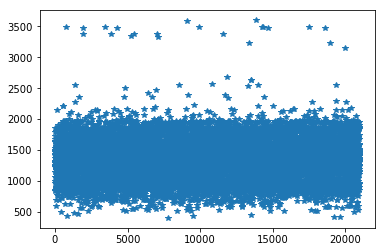

In [81]:
plt.plot(y_pred,'*')

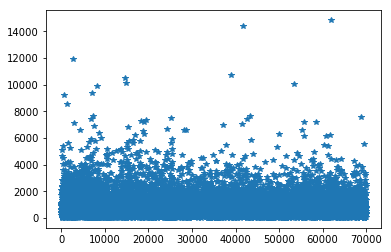

In [83]:
plt.plot(y_test,'*')

In [86]:
y_pred[:10]

array([ 1420.05077147,  1503.93791547,  1060.72430318,   855.89017275,
        1426.4608481 ,  1429.13201379,  1504.23911161,  1647.92160332,
        1237.55681193,  1417.23661323])

In [87]:
y_test[:10]

,kwh
27995,1131.0
63592,236.0
31343,1096.0
22266,550.0
33144,740.0
3778,252.0
49243,214.0
46371,357.0
13894,3522.0
15900,393.0
